# Parameter Estimation for ODE Systems

In [5]:
using DifferentialEquations, Plots

$$
\begin{align}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\beta IS + \delta R\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \beta IS - \gamma I - \epsilon I\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I - \delta R\\
\frac{\mathrm{d}D}{\mathrm{d}t} &= \epsilon I
\end{align}
$$

In [8]:
function SIRDModel!(du, u, p, t)
  
  # unpack p
  β, γ, δ, ϵ = p

  # unpack u
  S, I, R, D = u

  # define equations
  dSdt = -β*I*S + δ*R
  dIdt = β*I*S - γ*I - ϵ*I
  dRdt = γ*I - δ*R
  dDdt = ϵ*I

  du[1:4] = [dSdt, dIdt, dRdt, dDdt]

  nothing # return nothing
end

SIRDModel! (generic function with 1 method)

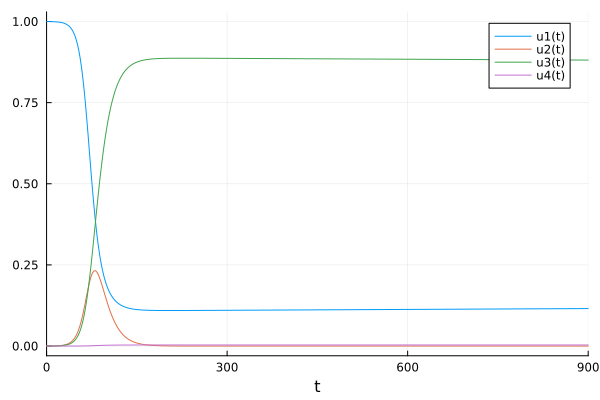

In [37]:
u0 = [0.9999, 0.0001, 0., 0.]
tspan = (0, 900)
p = [0.2, 0.08, 1e-5, 3e-4]

prob = ODEProblem(SIRDModel!, u0, tspan, p)
plot(solve(prob))

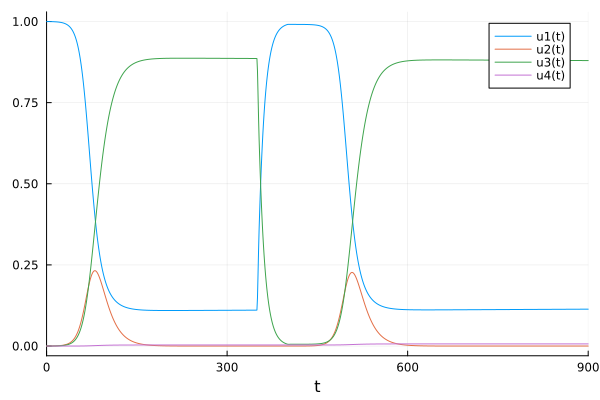

In [43]:
function δm(t)
  return 350 < t < 400 ? 1e-1 : 1e-5
end

function SIRDModelMutation!(du, u, p, t)
  
  # unpack p
  β, γ, ϵ = p

  # unpack u
  S, I, R, D = u

  # define equations
  dSdt = -β*I*S + δm(t)*R
  dIdt = β*I*S - γ*I - ϵ*I
  dRdt = γ*I - δm(t)*R
  dDdt = ϵ*I

  du[1:4] = [dSdt, dIdt, dRdt, dDdt]

  nothing # return nothing
end

u0 = [0.9999, 0.0001, 0., 0.]
tspan = (0, 900)
p = [0.2, 0.08, 3e-4]

prob = ODEProblem(SIRDModelMutation!, u0, tspan, p)
plot(solve(prob))